### Pydantic Example


In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz: str
    abc: str

In [17]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel, StrictStr


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    a: StrictStr

def node(state:OverallState):
    return {"a":"Hi I am Deepak"}

In [18]:
# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node)  # node_1 is the first node
builder.add_edge(START, "node")  # Start the graph with node_1
builder.add_edge("node", END)  # End the graph after node_1
graph = builder.compile()

In [19]:
graph.invoke({'a': 'Hello'})

{'a': 'Hi I am Deepak'}

In [20]:
try:
    graph.invoke({"a":123}) # should be a string
except Exception as e:
    print("Exception was raised because a value is integer")

In [21]:
graph.invoke({'a':123})

{'a': 'Hi I am Deepak'}

### Multiple Nodes - Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called(not when bad_node returns an update to the state which is in consistent with the schema).

In [22]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel

class OverallState(BaseModel):
    a:str

def bad_node(state:OverallState):
    return{
        'a':123 # Invalid
    }

def ok_node(state:OverallState):
    return {'a':'goodbye'}

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, 'bad_node')
builder.add_edge('bad_node', 'ok_node')
builder.add_edge('ok_node', END)
graph = builder.compile()

In [28]:
# Test the graph with a valid input
try:
    graph.invoke({'a':123.00})
except Excpetion as e:
    print("An exception was raised because bad_node sets 'a' to an integer.")
    print(e)

In [27]:
graph.invoke({'a':'Deepak'})

{'a': 'goodbye'}

### Prompt Chaining

Prompt chaining decomposes a task into sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and clearly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

In [30]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

llm = ChatGroq(model='llama3-70b-8192')
result = llm.invoke('Hello')
result


AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.074285714, 'prompt_time': 0.000128439, 'queue_time': 0.052475100999999996, 'total_time': 0.074414153}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run-3af366ae-a301-43b5-a113-f1b8a14926bf-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})

In [32]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [39]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}



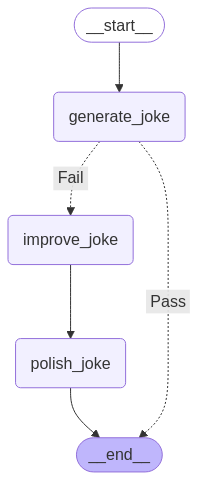

In [40]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [43]:
state = chain.invoke({"topic": "baby"})

In [44]:
state

{'topic': 'baby',
 'joke': 'Why did the baby\'s first word was "mama"?\n\nBecause it was the only word that came with a warranty!',
 'improved_joke': 'Here\'s a revised version with some added wordplay:\n\nWhy did the baby\'s first word have to be "mama"?\n\nBecause it was the only word that came with a mom-umental warranty, and the little one wanted to ensure they had a parent-al guarantee of love and care!',
 'final_joke': 'Here\'s a revised version with a surprising twist:\n\nWhy did the baby\'s first word have to be "mama"?\n\nBecause it was the only word that came with a mom-umental warranty, and the little one wanted to ensure they had a parent-al guarantee of love and care... but little did they know, the warranty was issued by a secret society of ninja moms, and the "care" clause included stealth training and a lifetime supply of ninja diapers!'}

In [46]:
state['improved_joke']

'Here\'s a revised version with some added wordplay:\n\nWhy did the baby\'s first word have to be "mama"?\n\nBecause it was the only word that came with a mom-umental warranty, and the little one wanted to ensure they had a parent-al guarantee of love and care!'

In [47]:
state['final_joke']

'Here\'s a revised version with a surprising twist:\n\nWhy did the baby\'s first word have to be "mama"?\n\nBecause it was the only word that came with a mom-umental warranty, and the little one wanted to ensure they had a parent-al guarantee of love and care... but little did they know, the warranty was issued by a secret society of ninja moms, and the "care" clause included stealth training and a lifetime supply of ninja diapers!'

### Parallelization

With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations:-

Sectioning: Breaking a task into independent subtask run in parallel.

Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Paralleleization is effective when the divided subtasks can be parrallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by the seperate LLM call, allowing focused attention on each specific aspect.

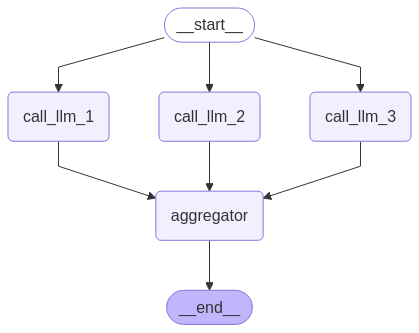

Here's a story, joke, and poem about cats!

STORY: 
**Whisker Tales**

In the sleepy town of Felinia, where sunbeams danced through the windows and catnip grew wild, a mystical realm thrived. Here, cats ruled supreme, their whims and fancies governing the world. A magical council, comprised of nine wise felines, governed the land, ensuring harmony and balance among all creatures.

Our tale begins with a curious, mischievous calico named Luna. Born with a spark of mischief in her eye, Luna loved to explore the hidden corners of Felinia. One day, while prowling through the Whispering Walls, a labyrinthine alleyway lined with ancient stones, she stumbled upon an enchanted artifact – the Golden Whisker of Fate.

Legend whispered that this whisker, forged from the essence of the first cat, held the power to shape destiny. Luna, intrigued by the whispers, decided to investigate further. As she grasped the whisker, a sudden, blinding flash illuminated the alley. When the light faded, Luna dis

In [50]:
# Graph state
class State(TypedDict):
    topic:str
    joke:str
    story:str
    poem:str
    combined_output:str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state:State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a astory about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    """Combine the joke, story and poem into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY: \n{state['story']}\n\n"
    combined += f"JOKE: \n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])